In [ ]:
!pip install torch transformers nltk scikit-learn
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
from sklearn.datasets import fetch_20newsgroups
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Load the dataset
categories = None # Define categories if you want to filter, else None to load all
train_data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

# Initialize the PorterStemmer
stemmer = PorterStemmer()

# Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed)

# Preprocess the dataset
train_data.data = [preprocess_text(text) for text in train_data.data]
test_data.data = [preprocess_text(text) for text in test_data.data]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(train_data.data, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_data.data, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class NewsGroupDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsGroupDataset(train_encodings, train_data.target)
test_dataset = NewsGroupDataset(test_encodings, test_data.target)

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_data.target_names))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy='steps',
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
500,2.279400,1.491178
1000,1.303600,1.269771
1500,1.096300,1.247410
2000,0.880500,1.164771
2500,0.818400,1.129275
3000,0.703400,1.143849
3500,0.486200,1.184391
4000,0.469000,1.200187


TrainOutput(global_step=4245, training_loss=0.9732589434117114, metrics={'train_runtime': 5027.6536, 'train_samples_per_second': 6.751, 'train_steps_per_second': 0.844, 'total_flos': 8931958743932928.0, 'train_loss': 0.9732589434117114, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.1962834596633911,
 'eval_runtime': 230.2571,
 'eval_samples_per_second': 32.711,
 'eval_steps_per_second': 4.091,
 'epoch': 3.0}

In [ ]:
import numpy as np

def compute_accuracy(trainer, dataset):
    # Generate predictions
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=-1)

    # Calculate accuracy
    accuracy = (preds == predictions.label_ids).mean()
    return accuracy

# Calculate accuracies
train_accuracy = compute_accuracy(trainer, train_dataset)
test_accuracy = compute_accuracy(trainer, test_dataset)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.9165635495845855
Test Accuracy: 0.7012745618693574


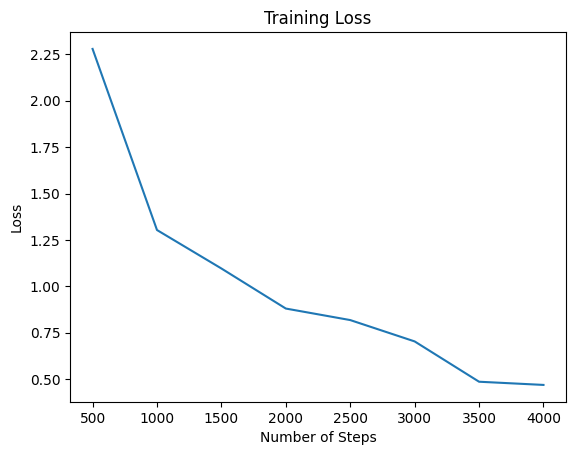

In [ ]:
import matplotlib.pyplot as plt

# Extract loss from trainer's log history
losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
plt.plot(steps, losses)
plt.title('Training Loss')
plt.xlabel('Number of Steps')
plt.ylabel('Loss')
plt.show()

In [ ]:
print(trainer.state.log_history)

[{'loss': 2.2794, 'grad_norm': 9.555865287780762, 'learning_rate': 5e-05, 'epoch': 0.35, 'step': 500}, {'eval_loss': 1.4911777973175049, 'eval_runtime': 230.7044, 'eval_samples_per_second': 32.648, 'eval_steps_per_second': 4.083, 'epoch': 0.35, 'step': 500}, {'loss': 1.3036, 'grad_norm': 14.08055305480957, 'learning_rate': 4.332443257676902e-05, 'epoch': 0.71, 'step': 1000}, {'eval_loss': 1.269770622253418, 'eval_runtime': 229.6927, 'eval_samples_per_second': 32.792, 'eval_steps_per_second': 4.101, 'epoch': 0.71, 'step': 1000}, {'loss': 1.0963, 'grad_norm': 13.866167068481445, 'learning_rate': 3.6648865153538056e-05, 'epoch': 1.06, 'step': 1500}, {'eval_loss': 1.2474098205566406, 'eval_runtime': 230.0377, 'eval_samples_per_second': 32.742, 'eval_steps_per_second': 4.095, 'epoch': 1.06, 'step': 1500}, {'loss': 0.8805, 'grad_norm': 21.541471481323242, 'learning_rate': 2.9973297730307076e-05, 'epoch': 1.41, 'step': 2000}, {'eval_loss': 1.1647706031799316, 'eval_runtime': 230.3522, 'eval_s

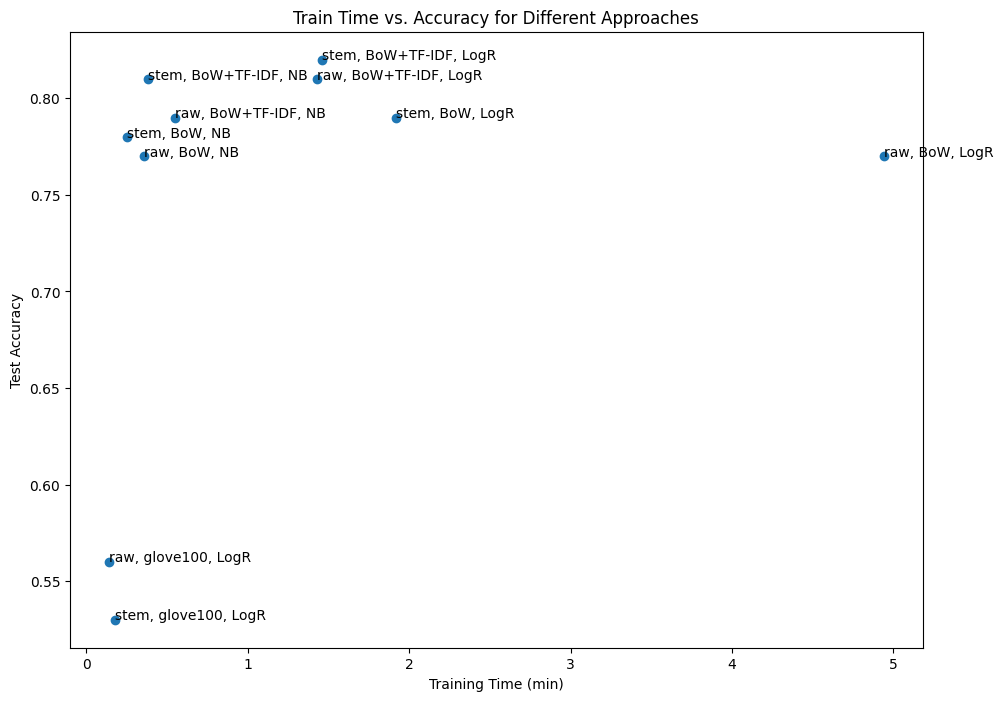

In [ ]:
import matplotlib.pyplot as plt

x = [0.36, 0.55, 0.25, 0.38, 4.94, 1.43, 1.92, 1.46, 0.14, 0.18]
y = [0.77, 0.79, 0.78, 0.81, 0.77, 0.81, 0.79, 0.82, 0.56, 0.53]
n = ['raw, BoW, NB', 'raw, BoW+TF-IDF, NB', 'stem, BoW, NB', 'stem, BoW+TF-IDF, NB', 'raw, BoW, LogR', 'raw, BoW+TF-IDF, LogR', 'stem, BoW, LogR', 'stem, BoW+TF-IDF, LogR', 'raw, glove100, LogR', 'stem, glove100, LogR']

plt.figure(figsize=(11,8))
plt.xlabel('Training Time (min)')
plt.ylabel('Test Accuracy')
plt.title('Train Time vs. Accuracy for Different Approaches')
plt.scatter(x, y)

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))